# Creating a prediction system for fantasy basketball points

In this notebook we will create a Machine Learning architecture that will take information from previous years to predict a player's fantasy points. We will first test a few hypothesis of what statistics and information is easier to predict and then seeing how we can bring it together to make the best algorithm to predict a player's fantasy points.

We will start by first getting the data from the csv files into a pandas dataframe. Then we will edit it to remove things like NaN's. 

In [15]:
import tensorflow as tf
import numpy as np 
import pandas as pd 
import sklearn as sk
import random

player_tables={}
team_tables={}

years=range(2000,2022)
player_stats=["player_per_game", "player_per_36_min", "per_100_possesions"]
team_stats=["team_per_game", "team_per_100_possesions"]

for year in years:
    player_tables[year]={}
    team_tables[year]={}
    for stat in player_stats:
        player_tables[year][stat]=pd.read_csv("NBA_data/NBA_"+str(year)+"_"+stat+".csv", index_col=0)
        player_tables[year][stat]=player_tables[year][stat].dropna()
        player_tables[year][stat].insert(0, "year", year, True)
        player_tables[year][stat]=player_tables[year][stat].rename(columns={"player":"name"}) #this is so we can search for name as a query for players or teams
        player_tables[year][stat]["name"]=player_tables[year][stat]["name"].str.replace("*", "")
    for stat in team_stats:
        team_tables[year][stat]=pd.read_csv("NBA_data/NBA_"+str(year)+"_"+stat+".csv", index_col=0)
        team_tables[year][stat]=team_tables[year][stat].dropna()
        team_tables[year][stat].insert(0, "year", year, True)
        team_tables[year][stat]=team_tables[year][stat].rename(columns={"team_name":"name"})
        team_tables[year][stat]["name"]=team_tables[year][stat]["name"].str.replace("*", "")

In [16]:
player_tables[2021]["player_per_game"].head()

,year,name,pos,age,team_id,g,gs,mp_per_g,fg_per_g,fga_per_g,...,ft_pct,orb_per_g,drb_per_g,trb_per_g,ast_per_g,stl_per_g,blk_per_g,tov_per_g,pf_per_g,pts_per_g
0,2021,Precious Achiuwa,PF,21,MIA,61,4,12.1,2.0,3.7,...,0.509,1.2,2.2,3.4,0.5,0.3,0.5,0.7,1.5,5.0
2,2021,Steven Adams,C,27,NOP,58,58,27.7,3.3,5.3,...,0.444,3.7,5.2,8.9,1.9,0.9,0.7,1.3,1.9,7.6
3,2021,Bam Adebayo,C,23,MIA,64,64,33.5,7.1,12.5,...,0.799,2.2,6.7,9.0,5.4,1.2,1.0,2.6,2.3,18.7
4,2021,LaMarcus Aldridge,C,35,TOT,26,23,25.9,5.4,11.4,...,0.872,0.7,3.8,4.5,1.9,0.4,1.1,1.0,1.8,13.5
5,2021,Ty-Shon Alexander,SG,22,PHO,15,0,3.1,0.2,0.8,...,0.500,0.1,0.5,0.7,0.4,0.0,0.1,0.2,0.1,0.6


In [17]:
team_tables[2020]["team_per_game"].head()

,year,ast,blk,drb,fg,fg2,fg2_pct,fg2a,fg3,fg3_pct,...,fta,g,mp,orb,pf,pts,stl,name,tov,trb
1,2020,24.7,4.8,36.4,41.7,26.5,0.541,49.0,15.1,0.367,...,23.8,75.0,242.3,10.5,19.5,117.0,6.1,Dallas Mavericks,12.7,46.9
2,2020,25.9,5.9,42.2,43.3,29.5,0.567,52.0,13.8,0.355,...,24.7,73.0,241.0,9.5,19.6,118.7,7.2,Milwaukee Bucks,15.1,51.7
3,2020,20.6,6.1,35.1,42.2,29.3,0.514,57.1,12.9,0.377,...,22.1,74.0,241.0,10.2,21.7,115.0,6.3,Portland Trail Blazers,12.8,45.3
4,2020,21.6,5.2,34.5,40.8,25.1,0.557,45.2,15.6,0.345,...,26.1,72.0,241.4,9.8,21.8,117.8,8.7,Houston Rockets,14.7,44.3
5,2020,23.7,4.7,37.0,41.6,29.1,0.522,55.8,12.4,0.371,...,26.3,72.0,241.4,10.7,22.1,116.3,7.1,Los Angeles Clippers,14.6,47.7


# Helper functions

We will make some functions that will make it easy to use the data we have as we are using a different data structure. We might want to make some queries along multiple tables for example. With this in mind we will make multiple functions that will aide in these kind of common tasks.

In [18]:
def find(tables, names, years=True, stats=True):
    """
    tables is a nested dictionary representing information by years and then by type of stats
    name is a string representing the player or team we want to query
    years is list of years we want to look for, if True it looks for all possible years
    stats is list of type of stats we want to find, if True it looks for all type of stats

    This function will look through all the tables given desired years and stat types and will return a pandas dataframe with all the information that agrees with the search

    returns table a pandas dataframe with all results that match the search.
    """
    if isinstance(names, str):
        names = [names]
    if years == True:
        years = list(tables.keys())
    if isinstance(years, int):
        years=[years]
    if stats == True:
        stats = list(tables[years[0]].keys())
    if isinstance(stats, str):
        stats = [stats]

    all_names=False
    if names == ["all"]:
        all_names=True
    
    table=pd.DataFrame()
    for year in years:
        for stat in stats:
            data=tables[year][stat]
            if all_names:
                table=pd.concat([table,data], axis=0)
            else:
                for name in names:
                    table=pd.concat([table,data[data["name"]==name]], axis=0)
    return table.reset_index(drop=True)

def divide_val_set(data, percent=.2):
    """
    data is most likely a dataframe (or list) that has the information we want
    percent is a float that selets wanted validation percent

    This function takes a given percent and will divide the data into test and validation sets.

    returns a test and validation sets.
    """
    n=len(data)
    n1=int(n*(1-percent))
    return data[:n1], data[n1:]



## Examples

In [19]:
find(player_tables, "James Harden", stats="player_per_game")

,year,name,pos,age,team_id,g,gs,mp_per_g,fg_per_g,fga_per_g,...,ft_pct,orb_per_g,drb_per_g,trb_per_g,ast_per_g,stl_per_g,blk_per_g,tov_per_g,pf_per_g,pts_per_g
0,2010,James Harden,SG,20,OKC,76,0,22.9,3.1,7.6,...,0.808,0.6,2.6,3.2,1.8,1.1,0.3,1.4,2.6,9.9
1,2011,James Harden,SG,21,OKC,82,5,26.7,3.6,8.3,...,0.843,0.5,2.6,3.1,2.1,1.1,0.3,1.3,2.5,12.2
2,2012,James Harden,SG,22,OKC,62,2,31.4,5.0,10.1,...,0.846,0.5,3.6,4.1,3.7,1.0,0.2,2.2,2.4,16.8
3,2013,James Harden,SG,23,HOU,78,78,38.3,7.5,17.1,...,0.851,0.8,4.1,4.9,5.8,1.8,0.5,3.8,2.3,25.9
4,2014,James Harden,SG,24,HOU,73,73,38.0,7.5,16.5,...,0.866,0.8,3.9,4.7,6.1,1.6,0.4,3.6,2.4,25.4
5,2015,James Harden,SG,25,HOU,81,81,36.8,8.0,18.1,...,0.868,0.9,4.7,5.7,7.0,1.9,0.7,4.0,2.6,27.4
6,2016,James Harden,SG,26,HOU,82,82,38.1,8.7,19.7,...,0.860,0.8,5.3,6.1,7.5,1.7,0.6,4.6,2.8,29.0
7,2017,James Harden,PG,27,HOU,81,81,36.4,8.3,18.9,...,0.847,1.2,7.0,8.1,11.2,1.5,0.5,5.7,2.7,29.1
8,2018,James Harden,SG,28,HOU,72,72,35.4,9.0,20.1,...,0.858,0.6,4.8,5.4,8.8,1.8,0.7,4.4,2.3,30.4
9,2019,James Harden,PG,29,HOU,78,78,36.8,10.8,24.5,...,0.879,0.8,5.8,6.6,7.5,2.0,0.7,5.0,3.1,36.1


## Test with Neural Nets

We will begin testing by using some simple Neural Networks to test our hypotheses. We use an infrastructure that is simple yet specific for our task of predicting a time series so that we can get evidence for what is the best direction to take when building a more complex structure.

We will look at predictions made with a model having a few dense layers, really simple one using a RNN and one using an LSTM model.

In [76]:
# Create our datasets
random.seed(0) #This is so that when we divide the datasets we get test and prediction data in the corresponding place while randomizing selection

names=False
for year in range(2016,2022):
    if not names:
        names=set(player_tables[year]["player_per_game"]["name"].tolist())
    else:
        names=names&set(player_tables[year]["player_per_game"]["name"].tolist())
names=list(names)

stats=["fg_per_g", "age", "gs", "pts_per_g", "trb_per_g", "ast_per_g", "stl_per_g", "mp_per_g", "blk_per_g", "fg3_per_g"]

data=find(player_tables, names, years=2020, stats="player_per_game")[stats]
for_rnn=find(player_tables, names, years=range(2016,2021), stats="player_per_game")[stats+["name"]]
pred=find(player_tables, names, years=2021, stats="player_per_game")[stats]

data_rnn=[]

for name in names:
    data_rnn.append(for_rnn[for_rnn["name"]==name].drop(columns=["name"]).to_numpy())
data_rnn=np.array(data_rnn)

test_data, val_data=divide_val_set(data)
test_pred, val_pred=divide_val_set(pred)
test_data_rnn, val_data_rnn=divide_val_set(data_rnn) 

tf.keras.backend.set_floatx('float64')

# Dense Layers
dense1=tf.keras.Sequential(tf.keras.layers.Dense(10))
dense1.compile(loss='mse', optimizer='adam')
dense1.fit(test_data.to_numpy(),test_pred.to_numpy())

dense2=tf.keras.Sequential([tf.keras.layers.Dense(10), tf.keras.layers.Dense(10)])
dense2.compile(loss='mse', optimizer='adam')
dense2.fit(test_data.to_numpy(),test_pred.to_numpy())

# Simple RNN
rnn=tf.keras.Sequential(tf.keras.layers.SimpleRNN(10))
rnn.compile(loss='mse', optimizer='adam')
rnn.fit(test_data_rnn,test_pred.to_numpy())

# LSTM
lstm=tf.keras.Sequential(tf.keras.layers.LSTM(10))
lstm.compile(loss='mse', optimizer='adam')
lstm.fit(test_data_rnn,test_pred.to_numpy())

models={"dense1":dense1, "dense2":dense2, "rnn":rnn, "lstm":lstm}

#Evaluation
from sklearn.metrics import mean_squared_error
errors={}
for model in models.keys():
    if "dense" in model:
        errors[model]=mean_squared_error(models[model](val_data.to_numpy()), val_pred.to_numpy())
    else:
        errors[model]=mean_squared_error(models[model](val_data_rnn), val_pred.to_numpy())

for model in errors.keys():
    print(model, errors[model])

4/4 [==============================] - 1s 2ms/step - loss: 324.7089
dense1 421.08475288478786
dense2 1293.0312075039542
rnn 310.5228093961331
lstm 293.7957218065534


# Analyzing results

We see from the training and from the mean squared error we use to evaluate at the end that the RNN's get better results in this task than a regular NN, also noticing that adding more dense layers performs much better than a single one. We also notice that likely due to the small length of the temporal data the LSTM performs around equal or worse than the simple RNN. Another thing to notice is that the there is a small difference between the loss in the training and validation sets which is evidence that the model is not overfitting. One question we may want to ask is if the reason these models execute better is only because they have information of 5 years or if it is because this is temporal data. We will now test below a dense layer where we have as inputs the data of the 5 years.

Note: after running it multiple times the execution of the dense layers has a lot of variance dome models being really close to the RNN's performance (which is consistent) and some having almost 4 times the loss compared to the RNN's.

In [21]:
len(names)

129

In [22]:
data_years=[]
for name in names:
    data_years.append(for_rnn[for_rnn["name"]==name].drop(columns=["name"]).to_numpy().flatten())
data_years=np.array(data_years)

test_data_years, val_data_years=divide_val_set(data_years) 

dense_years1=tf.keras.Sequential(tf.keras.layers.Dense(10))
dense_years1.compile(loss='mse', optimizer='adam')
dense_years1.fit(test_data_years,test_pred.to_numpy())

dense_years2=tf.keras.Sequential([tf.keras.layers.Dense(10),tf.keras.layers.Dense(10)])
dense_years2.compile(loss='mse', optimizer='adam')
dense_years2.fit(test_data_years,test_pred.to_numpy())

print("dense_years1", mean_squared_error(dense_years1(val_data_years), val_pred.to_numpy()))
print("dense_years2", mean_squared_error(dense_years2(val_data_years), val_pred.to_numpy()))

4/4 [==============================] - 0s 666us/step - loss: 702.1607
dense_years1 2009.2794272051353
dense_years2 500.54635728865526


We do not see an improvement, especially up to the level of the RNN using this data where we have now used the information of 5 years to predict the next one. This shows that indeed the temporal structure does provide information that makes for a better prediction.

# Comparing team to player data

We now want to make a comparison between how well a RNN can predict a team's stats compared with predicting player's stats. The first issue we need to tackle is that the scale of these stats is different and to make a fair comparison we need to normalize our data so that we can compare the execution of our models.

## Start with some histograms

We want to normalize the data, but it is important to understand how the data points look like. For example for players points will look really skewed with a peak probably lower than 10 points and few players with high 20s or even 30. But points for teams may look closer to a normal distribution. We will analize some distribution for these stats.

In [23]:
stats=["fg_per_g", "age", "gs", "pts_per_g", "orb_per_g", "drb_per_g", "trb_per_g", "ast_per_g", "stl_per_g", "mp_per_g", "blk_per_g", "fg3_per_g"]
all_player_data=find(player_tables,"all")[stats]

## Player data

Let us start by studying the first stat I just mentioned above, points per game. We will make some histograms of this information throughout the years to see how the distribution looks like.

array([[<AxesSubplot:title={'center':'pts_per_g'}>]], dtype=object)

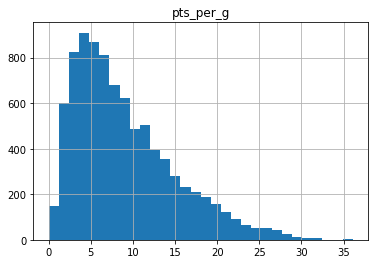

In [24]:
all_player_data.hist(column="pts_per_g",bins=30)

C:\Users\xnive\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


array([[<AxesSubplot:title={'center':'pts_per_g'}>]], dtype=object)

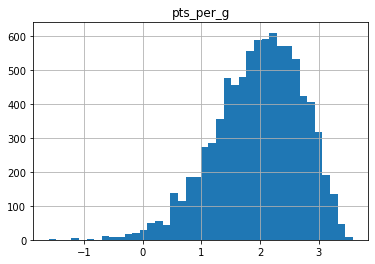

In [25]:
log_player_data=np.log(all_player_data)
log_player_data[log_player_data["pts_per_g"]!=-np.inf].hist(column="pts_per_g",bins=40)

As we can see from the two histograms above the log of pts per game might be better to make predictions (after normalizing) as it is closer to a normal distribution. Although clearly it is still a distribution that has many outliers but now they are to the left opposed to the right for our original data.

array([[<AxesSubplot:title={'center':'mp_per_g'}>]], dtype=object)

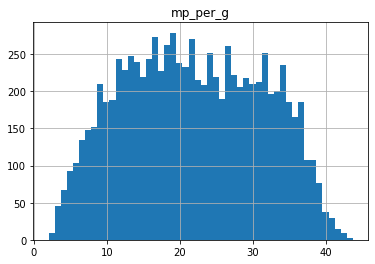

In [26]:
all_player_data.hist(column="mp_per_g",bins=50)

As we can see from the histogram above minutes played (mp_per_game) per game is closer to a normal distribution and has more simmetry to it. These stats (normalized) would work out well to make predictions.

We won't look at the histograms of field goals per game or triples per game as we may expect them to be closely related to the points per game and thus have similar distributions (skewed to the left). So we will now look at (total) rebounts per game (trb_per_g) and at games started (gs)

array([[<AxesSubplot:title={'center':'trb_per_g'}>]], dtype=object)

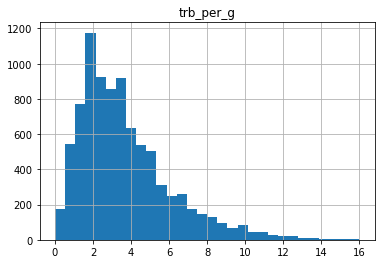

In [27]:
all_player_data.hist(column="trb_per_g",bins=30)

array([[<AxesSubplot:title={'center':'gs'}>]], dtype=object)

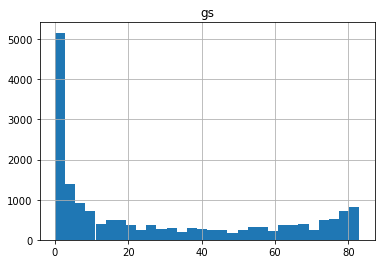

In [28]:
all_player_data.hist(column="gs",bins=30)

As we can see rebounds has a similar shape to that of pts per game, while games started has a pretty unique distribution that is more loaded at both ends. This might be better to use as is (normalized) and think of it to be similar to a binary distribution. 

## Team data

We will now study similar statistics for teams and compare this distributions and decide on the best way to normalize our data.

In [29]:
stats=["fg", "pts", "orb", "drb", "trb", "ast", "stl", "blk", "fg3"]
all_team_data=find(team_tables, "all")[stats]

array([[<AxesSubplot:title={'center':'pts'}>]], dtype=object)

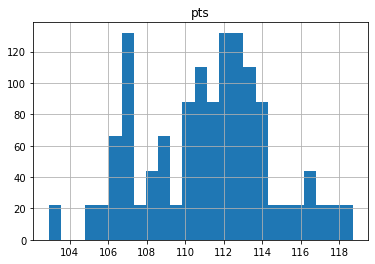

In [30]:
all_team_data.hist(column=["pts"], bins=25)

array([[<AxesSubplot:title={'center':'trb'}>]], dtype=object)

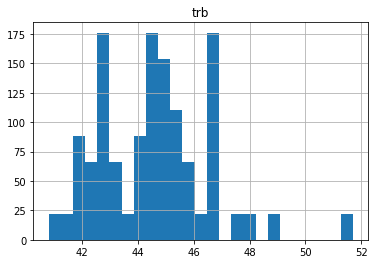

In [31]:
all_team_data.hist(column=["trb"], bins=25)

array([[<AxesSubplot:title={'center':'stl'}>]], dtype=object)

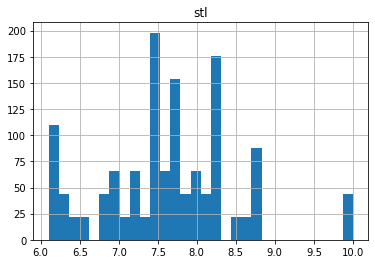

In [32]:
all_team_data.hist(column=["stl"], bins=30)

Looking at the histograms above we see that the distributions for team data are less "nice" and we might expect the predictions made with team data to be less accurate. I decided that for these distributions as they do not seem partticularly skewed to any side and due to their irregularities to normalize from the data as is.

# Normalized predictions

Now that we have decided how to normalize our data lets do a new prediction now that means are adjusted to 0 and standard deviation is set to 1.

In [33]:
player_stats=["gs", "mp_per_g", "blk_per_g", "fg_per_g", "age", "pts_per_g", "orb_per_g", "drb_per_g", "trb_per_g", "ast_per_g", "stl_per_g", "fg3_per_g"]
player_log_stats=["fg_per_g", "age", "pts_per_g", "orb_per_g", "drb_per_g", "trb_per_g", "ast_per_g", "stl_per_g", "blk_per_g", "fg3_per_g"] #blocks is also skewed and even log is skewed but I feel it is better to at least do that transformation as well
player_team_stats=["fg_per_g", "pts_per_g", "orb_per_g", "drb_per_g", "trb_per_g", "ast_per_g", "stl_per_g", "blk_per_g", "fg3_per_g"]
team_stats=["fg", "pts", "orb", "drb", "trb", "ast", "stl", "blk", "fg3"]

#to decide which were log and which not, I did look at all tables but I felt it wouldn't be as insightful to go over everything above.

In [34]:
def normalize(data):
    """
    data a pandas dataframe that we want to normalize.

    This function will normalize the data and will also return functions to "denormalize" the data back to normal.

    returns normalized_data, normalizers    normalized data is the normalized data and normalizer and denormalizersare dictionaries that contains the information to define functions                                             and inverse functions to normalize every column of data
    """
    normalizers={}
    normalized_data=pd.DataFrame()
    for col in data.columns:
        if col!="name":
            mean=np.mean(data[col])
            std=np.std(data[col])
            normalized_data[col]=(data[col]-mean)/std
            normalizers[col]=(mean,std)
        else:
            normalized_data[col]=data[col]
    return normalized_data, normalizers

def denormalize(data, normalizers):
    """
    data is a pandas dataframe
    normalizer is a dictionary as in the function above containing for every column of data a value of its previous mean and std

    This function reverts normalized data to its original state

    returns denormalized_data
    """
    denormalized_data=pd.DataFrame()
    for col in data.columns:
        denormalized_data[col]=(normalizers[col][1]*data[col])+normalizers[col][0]
    return denormalized_data

In [44]:
for_rnn

,gs,mp_per_g,blk_per_g,fg_per_g,age,pts_per_g,orb_per_g,drb_per_g,trb_per_g,ast_per_g,stl_per_g,fg3_per_g,name
0,7,29.3,0.4,4.7,22,12.7,1.7,4.7,6.4,1.3,0.4,0.4,Michael Kidd-Gilchrist
1,69,29.4,0.3,4.4,21,10.7,1.1,2.5,3.6,6.4,1.2,0.4,Elfrid Payton
2,80,34.8,0.3,8.0,24,20.8,0.6,2.7,3.2,4.3,1.2,2.5,CJ McCollum
3,2,14.5,0.0,1.9,25,5.1,0.5,1.6,2.2,3.2,0.6,0.3,Tim Frazier
4,79,36.1,0.2,6.4,24,18.2,0.6,3.3,3.8,4.2,1.7,1.8,Khris Middleton
...,...,...,...,...,...,...,...,...,...,...,...,...,...
743,77,31.8,0.4,3.7,29,10.5,0.6,3.4,3.9,1.8,1.5,2.0,Justin Holiday
744,77,34.9,0.5,8.2,29,21.2,0.7,5.3,6.0,6.2,1.1,0.1,DeMar DeRozan
745,12,17.6,0.2,2.2,27,6.0,0.4,1.7,2.1,0.9,0.4,1.1,Tony Snell
746,60,27.5,0.4,3.0,24,8.9,0.7,2.2,2.9,4.0,1.8,1.6,Marcus Smart


## Preparing data

In [77]:
from copy import copy, deepcopy

#get data

names=False
for year in range(2016,2022):
    if not names:
        names=set(player_tables[year]["player_per_game"]["name"].tolist())
    else:
        names=names&set(player_tables[year]["player_per_game"]["name"].tolist())
names=list(names)

teams=team_tables[year]["team_per_game"]["name"].tolist()


for_rnn=find(player_tables, names, years=range(2016,2021), stats="player_per_game")[player_stats+["name"]]
player_pred=find(player_tables, names, years=2021, stats="player_per_game")[player_team_stats]
for_rnn_team=find(team_tables, teams, years=range(2016,2021), stats="team_per_game")[team_stats+["name"]]
team_pred=find(team_tables, teams, years=2021, stats="team_per_game")[team_stats]

#transform data to how we want to use it

log_for_rnn=deepcopy(for_rnn)
log_player_pred=deepcopy(player_pred)

for stat in player_log_stats:
    log_for_rnn[stat]=np.log(log_for_rnn[stat])
    min_rep=np.min(log_for_rnn[log_for_rnn[stat]!=-np.inf][stat].to_numpy())
    for index in log_for_rnn[log_for_rnn[stat]==-np.inf].index:
        log_for_rnn[stat][index]=min_rep #replace -inf for minimum value from other players
    if stat in player_team_stats:
        log_player_pred[stat]=np.log(log_player_pred[stat])
        min_rep=np.min(log_player_pred[log_player_pred[stat]!=-np.inf][stat].to_numpy())
        for index in log_player_pred[log_player_pred[stat]==-np.inf].index:
            log_player_pred[stat][index]=min_rep


#normalize

for_rnn,player_normalizer=normalize(for_rnn)
log_for_rnn,log_player_normalizer=normalize(log_for_rnn)
for_rnn_team,team_normalizer=normalize(for_rnn_team)

#Make into temporal data

player_data=[]
log_player_data=[]
team_data=[]

for name in names:
    player_data.append(for_rnn[for_rnn["name"]==name].drop(columns=["name"]).to_numpy())
    log_player_data.append(log_for_rnn[log_for_rnn["name"]==name].drop(columns=["name"]).to_numpy())
for team in teams:
    team_data.append(for_rnn_team[for_rnn_team["name"]==team].drop(columns=["name"]).to_numpy())
player_data=np.array(player_data)
log_player_data=np.array(log_player_data)
team_data=np.array(team_data)


#make test and validation sets

test_player_data, val_player_data=divide_val_set(player_data)
test_player_pred, val_player_pred=divide_val_set(player_pred)

test_log_player_data, val_log_player_data=divide_val_set(log_player_data)
test_log_player_pred, val_log_player_pred=divide_val_set(log_player_pred)

test_team_data, val_team_data=divide_val_set(team_data)
test_team_pred, val_team_pred=divide_val_set(team_pred)

C:\Users\xnive\anaconda3\envs\tf\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\xnive\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\xnive\anaconda3\envs\tf\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\xnive\anaconda3\envs\tf\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\xnive\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

In [36]:
player_stats

['gs',
 'mp_per_g',
 'blk_per_g',
 'fg_per_g',
 'age',
 'pts_per_g',
 'orb_per_g',
 'drb_per_g',
 'trb_per_g',
 'ast_per_g',
 'stl_per_g',
 'fg3_per_g']

## Training

In [51]:
player_data.shape

(129, 6, 12)

In [48]:
test_player_data.shape

(103, 6, 12)

In [53]:
test_player_pred.shape

(103, 9)

In [78]:
#players rnn
rnn_players=tf.keras.Sequential(tf.keras.layers.SimpleRNN(9))
rnn_players.compile(loss='mse', optimizer='adam')
rnn_players.fit(test_player_data,test_player_pred.to_numpy(), batch_size=1, epochs=1, verbose=1)

#players rnn
rnn_log_players=tf.keras.Sequential(tf.keras.layers.SimpleRNN(9))
rnn_log_players.compile(loss='mse', optimizer='adam')
rnn_log_players.fit(test_log_player_data,test_log_player_pred.to_numpy(), batch_size=1, epochs=10, verbose=1)

#teams rnn
rnn_teams=tf.keras.Sequential(tf.keras.layers.SimpleRNN(9))
rnn_teams.compile(loss='mse', optimizer='adam')
rnn_teams.fit(test_team_data,test_team_pred.to_numpy(), batch_size=10)

models={"players":rnn_players, "log_players":rnn_log_players, "team":rnn_teams}
data_dict={"players":val_player_data, "log_players":val_log_player_data, "team":val_team_data}
pred_dict={"players":val_player_pred, "log_players":val_log_player_pred, "team":val_team_pred}

#Evaluation
from sklearn.metrics import mean_squared_error
errors={}
for model in models.keys():
    errors[model]=mean_squared_error(models[model](data_dict[model]), pred_dict[model].to_numpy())

#validation error
for model in errors.keys():
    print(model, errors[model])

#denormalized error
normalizers={"players":player_normalizer, "log_players":log_player_normalizer, "team":team_normalizer}
denormalized_errors={}
denormalized_preds={}
for model in models.keys():
    denormalized_errors[model]=models[model](data_dict[model]) #predictions
    denormalized_preds[model]=pred_dict[model]
    if model=="log_players":
        denormalized_errors[model]*=np.array([normalizers[model][stat][1] for stat in player_team_stats])
        denormalized_errors[model]+=np.array([normalizers[model][stat][0] for stat in player_team_stats])
        denormalized_errors[model]=np.exp(denormalized_errors[model])

        denormalized_preds[model]*=np.array([normalizers[model][stat][1] for stat in player_team_stats])
        denormalized_preds[model]+=np.array([normalizers[model][stat][0] for stat in player_team_stats])
        denormalized_preds[model]=np.exp(denormalized_preds[model])

    elif model=="team":
        denormalized_errors[model]*=np.array([normalizers[model][stat][1] for stat in team_stats])
        denormalized_errors[model]+=np.array([normalizers[model][stat][0] for stat in team_stats])

        denormalized_preds[model]*=np.array([normalizers[model][stat][1] for stat in team_stats])
        denormalized_preds[model]+=np.array([normalizers[model][stat][0] for stat in team_stats])

    else:
        denormalized_errors[model]*=np.array([normalizers[model][stat][1] for stat in player_team_stats])
        denormalized_errors[model]+=np.array([normalizers[model][stat][0] for stat in player_team_stats])

        denormalized_preds[model]*=np.array([normalizers[model][stat][1] for stat in player_team_stats])
        denormalized_preds[model]+=np.array([normalizers[model][stat][0] for stat in player_team_stats])

    denormalized_errors[model]=mean_squared_error(denormalized_errors[model], denormalized_preds[model].to_numpy())

for model in errors.keys():
    print(model, denormalized_errors[model])

125/125 [==============================] - 0s 677us/step - loss: 29.6095
Epoch 1/10
125/125 [==============================] - 1s 694us/step - loss: 2.0080
Epoch 2/10
125/125 [==============================] - 0s 669us/step - loss: 1.7288
Epoch 3/10
125/125 [==============================] - 0s 669us/step - loss: 1.3914
Epoch 4/10
125/125 [==============================] - 0s 669us/step - loss: 1.2198
Epoch 5/10
125/125 [==============================] - 0s 661us/step - loss: 1.1034
Epoch 6/10
125/125 [==============================] - 0s 661us/step - loss: 0.8499
Epoch 7/10
125/125 [==============================] - 0s 669us/step - loss: 0.7876
Epoch 8/10
125/125 [==============================] - 0s 653us/step - loss: 0.7590
Epoch 9/10
125/125 [==============================] - 0s 685us/step - loss: 0.6711
Epoch 10/10
3/3 [==============================] - 0s 2ms/step - loss: 2070.9245
players 26.958021562667078
log_players 0.7448744438073328
team 1889.8868325959609
players 743.15115

## Conclusions

As we saw above the execution of the log predictions is much better than that of the regular player predictions. It is staggering that the loss for the training data is quite small for the player data, but in the validation it is much higher, even that the team data which we could say in comparison that generalized better. We also did a final test of evaluating how the loss looks with our actual data once we reverse the normalization process (and the log conversion). This might be specially important as if we had a normalized loss of lets say 5 for log data and 10 for regular data, we may be tempted to say this makes better predictions, but when we convert the data back due to the log conversion we might see a bigger loss. In this case the difference is pretty big and once we convert back we see the log data still performs better but, we need to make sure of this.

# Lets make next season predictions

In [79]:
names=False
for year in range(2017,2022):
    if not names:
        names=set(player_tables[year]["player_per_game"]["name"].tolist())
    else:
        names=names&set(player_tables[year]["player_per_game"]["name"].tolist())
names=list(names)

teams=team_tables[year]["team_per_game"]["name"].tolist()


for_rnn=find(player_tables, names, years=range(2017,2021), stats="player_per_game")[player_stats+["name"]]
player_pred=find(player_tables, names, years=2021, stats="player_per_game")[player_team_stats]

#transform data to how we want to use it

log_for_rnn=deepcopy(for_rnn)
log_player_pred=deepcopy(player_pred)

for stat in player_log_stats:
    log_for_rnn[stat]=np.log(log_for_rnn[stat])
    min_rep=np.min(log_for_rnn[log_for_rnn[stat]!=-np.inf][stat].to_numpy())
    for index in log_for_rnn[log_for_rnn[stat]==-np.inf].index:
        log_for_rnn[stat][index]=min_rep #replace -inf for minimum value from other players
    if stat in player_team_stats:
        log_player_pred[stat]=np.log(log_player_pred[stat])
        min_rep=np.min(log_player_pred[log_player_pred[stat]!=-np.inf][stat].to_numpy())
        for index in log_player_pred[log_player_pred[stat]==-np.inf].index:
            log_player_pred[stat][index]=min_rep

#normalize

log_for_rnn,log_player_normalizer=normalize(log_for_rnn)

#Make into temporal data

log_player_data=[]

for name in names:
    log_player_data.append(log_for_rnn[log_for_rnn["name"]==name].drop(columns=["name"]).to_numpy())
log_player_data=np.array(log_player_data)

C:\Users\xnive\anaconda3\envs\tf\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\xnive\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\xnive\anaconda3\envs\tf\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\xnive\anaconda3\envs\tf\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\xnive\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

In [82]:
points_df=pd.DataFrame()
for i in range(193):
    points=rnn_log_players(np.array([log_player_data[i]]))[0]
    points*=np.array([log_player_normalizer[stat][1] for stat in player_team_stats])
    points+=np.array([log_player_normalizer[stat][0] for stat in player_team_stats])
    points=np.array([points[x] for x in [1,4,5,6,7,8]])
    points=np.exp(points)
    points*=np.array([0.5,1.5,1.5,3,3,1])
    points=np.sum(points)
    points*=66
    points_df[log_for_rnn["name"][i]]=[points]

In [83]:
stats_df=pd.DataFrame()
for i in range(193):
    points=rnn_log_players(np.array([log_player_data[i]]))[0]
    points*=np.array([log_player_normalizer[stat][1] for stat in player_team_stats])
    points+=np.array([log_player_normalizer[stat][0] for stat in player_team_stats])
    points=np.exp(points)
    stats_df[log_for_rnn["name"][i]]=points

In [84]:
points_df.transpose().sort_values(by=0, ascending=False).to_csv("point_predictions.csv")

In [85]:
stats_df.transpose().sort_values(by=1, ascending=False).to_csv("stat_predictions.csv")

# What's next?

We now played with the data and some simple models to see what we should work with. We now have evidence to sya it is better to use a RNN model to do predictions, that we should use not only player data as it is but instead take its log. The next step to work on this task will be to use the data we want to use and use a better model to make predictions in particular for this task. Another thing to do is to also make the data into the correct shape for our model and increase it size, as we only used the data from 2015 to 2020 when we can do the same for all years since 2000.

# Interlude

As I was thinking of what to do for the algorithm that will predict players averages, as I decided on the evidence above. I though that maybe the reason team data did not work as well as player data is that we have less data and it was trained on less informationm, a way to have more information for teams would be to make predictions based on their stats for one game instead of the average over a season. The reason why it may be good enough to do this for a team compared to a player is that the execution of a player on a game has a lot of variance but its average over a season not as much, but for teams this variance is much less. Maybe using our predictive power thought over as stats per game, instead of the average may make for better predictions.

A reason I want to understand team predictions is that understanding how to make predictions for a player at least as they are made every season considers what team the player is playing for. This could be because it is a high scoring team, or because there are (or aren't) other better players in their position and thus they play less (or more) and will thus have more stats per game. This could also be good to evaluate the success of a trade a team did. I would like to be able to use predictions for a team together with predictions for a player to make better predictions while correcting for discrepancies when seen from one side or the other.

# Even more thoughts

I thought about the log transformation and I think I would rather change it to be log(x+1) adding +1 solves one important issue that there are multiple players having 0 of certain stat and this then transforms into -inf, making it log(x+1) would make the minimum value 0 which would prevent this issue and still fixing the skedness of our distribution.

There are some thoughts on how useful it would be to do some clustering techniques to make more efficient predictions. For example by positions we expect different things and we may predict better, similarly for starters, role players, bench. There are also possibilities to do some other clustering techniques with the data, and while they might be good ideas there is the issue of the amount of data available. If we make a separate model for each type we thin our already small amount of data. I might try this out, but considering that we already "only" had 122 samples, which can be increased by using data throughout more years probably multiplying times 15, having a good size of training data may be more useful in the long run.